In [1]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pandas.read_csv('./ml-20m/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


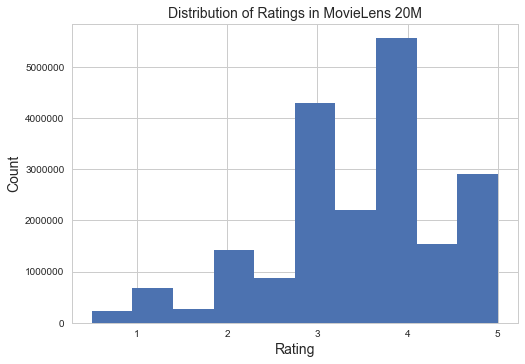

In [3]:
# Look at the distribution of rating data

plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 20M", fontsize=14)
plt.show()

In [4]:
# It looks like this is fairly normal distribution, with the most ratings being that 
# a movie was good but not amazing, and the fewest ratings that movies were very poor.

In [5]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 138493
# unique users:  138493

movie id min/max:  1 131262
# unique movies:  26744


In [6]:
# Based on the above results, let's quickly set these sizes so that later on we can set the embedding layer size appropriately.

In [7]:
n_users, n_movies = 138493, 131262
batch_size = 25000

In [8]:
n = 19000000

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

# Use the first 19M samples to train the model
train_users = data['userId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_movies = data['movieId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_ratings = data['rating'].values[:n]

# Use the remaining ~1M samples for validation of the model
valid_users = data['userId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_movies = data['movieId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_ratings = data['rating'].values[n:]

In [9]:
train_users.shape, train_movies.shape, train_ratings

((19000000,), (19000000,), array([ 2. ,  3. ,  3.5, ...,  4. ,  4. ,  5. ]))

In [10]:
valid_users.shape, valid_movies.shape, valid_ratings.shape

((1000263,), (1000263,), (1000263,))

In [11]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 58709.32 samples/sec	rmse=3.354239
INFO:root:Epoch[0] Batch [500]	Speed: 69498.21 samples/sec	rmse=1.797142
INFO:root:Epoch[0] Batch [750]	Speed: 70739.72 samples/sec	rmse=1.177943
INFO:root:Epoch[0] Train-rmse=1.065552
INFO:root:Epoch[0] Time cost=288.899
INFO:root:Epoch[0] Validation-rmse=1.061137
INFO:root:Epoch[1] Batch [250]	Speed: 69708.59 samples/sec	rmse=1.003390
INFO:root:Epoch[1] Batch [500]	Speed: 70686.03 samples/sec	rmse=0.938862
INFO:root:Epoch[1] Batch [750]	Speed: 71136.44 samples/sec	rmse=0.907462
INFO:root:Epoch[1] Train-rmse=0.898947
INFO:root:Epoch[1] Time cost=269.168
INFO:root:Epoch[1] Validation-rmse=0.899812
INFO:root:Epoch[2] Batch [250]	Speed: 69589.65 samples/sec	rmse=0.891166
INFO:root:Epoch[2] Batch [500]	Speed: 67890.87 samples/sec	rmse=0.883701
INFO:root:Epoch[2] Batch [750]	Speed: 71209.50 samples/sec	rmse=0.878407
INFO:root:Epoch[2] Train-rmse=0.877189
INFO:root:Epoch[2] Time cost=272.847
INFO:root:Epoch[2] Validati

In [12]:
# It looks like we're learning something on this dataset! We can see that both the training 
# and the validation RMSE decrease epoch by epoch.

In [13]:
# Let's now turn to deep matrix factorization

In [14]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer

nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)


model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 47058.47 samples/sec	rmse=1.589754
INFO:root:Epoch[0] Batch [500]	Speed: 46015.12 samples/sec	rmse=0.870415
INFO:root:Epoch[0] Batch [750]	Speed: 46051.11 samples/sec	rmse=0.862617
INFO:root:Epoch[0] Train-rmse=0.859145
INFO:root:Epoch[0] Time cost=409.989
INFO:root:Epoch[0] Validation-rmse=0.859440
INFO:root:Epoch[1] Batch [250]	Speed: 46841.25 samples/sec	rmse=0.854610
INFO:root:Epoch[1] Batch [500]	Speed: 48073.83 samples/sec	rmse=0.847587
INFO:root:Epoch[1] Batch [750]	Speed: 50262.16 samples/sec	rmse=0.840030
INFO:root:Epoch[1] Train-rmse=0.835775
INFO:root:Epoch[1] Time cost=392.487
INFO:root:Epoch[1] Validation-rmse=0.839420
INFO:root:Epoch[2] Batch [250]	Speed: 50386.74 samples/sec	rmse=0.833704
INFO:root:Epoch[2] Batch [500]	Speed: 49800.91 samples/sec	rmse=0.830574
INFO:root:Epoch[2] Batch [750]	Speed: 50301.05 samples/sec	rmse=0.828005
INFO:root:Epoch[2] Train-rmse=0.826103
INFO:root:Epoch[2] Time cost=378.531
INFO:root:Epoch[2] Validati

In [15]:
# Looks like we're getting a lower validation rmse after 5 epochs using deep matrix factorization 
# than with normal matrix factorization! That is a promising start that one could likely build on 
# by toying with the hyperparameters, activation functions, or structure of the network.

In [16]:
# It is important to keep in mind that we are training a neural network, and so all of the advances in deep learning 
# can be immediately applied to deep matrix factorization.


In [17]:
# A widely used advance was that of batch normalization, which essentially tried to shrink the range of values 
# that the internal nodes in a network

X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.BatchNorm(data=nn) # First batch norm layer here, before the activaton!
nn = mx.symbol.Activation(data=nn, act_type='relu') 
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.BatchNorm(data=nn) # Second batch norm layer here, before the activation!
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 18286.83 samples/sec	rmse=1.420668
INFO:root:Epoch[0] Batch [500]	Speed: 18861.39 samples/sec	rmse=0.857431
INFO:root:Epoch[0] Batch [750]	Speed: 18886.45 samples/sec	rmse=0.842832
INFO:root:Epoch[0] Train-rmse=0.837867
INFO:root:Epoch[0] Time cost=1017.050
INFO:root:Epoch[0] Validation-rmse=0.838686
INFO:root:Epoch[1] Batch [250]	Speed: 18970.67 samples/sec	rmse=0.831047
INFO:root:Epoch[1] Batch [500]	Speed: 18707.10 samples/sec	rmse=0.824250
INFO:root:Epoch[1] Batch [750]	Speed: 19007.59 samples/sec	rmse=0.819376
INFO:root:Epoch[1] Train-rmse=0.815406
INFO:root:Epoch[1] Time cost=1004.696
INFO:root:Epoch[1] Validation-rmse=0.832841
INFO:root:Epoch[2] Batch [250]	Speed: 19903.30 samples/sec	rmse=0.806077
INFO:root:Epoch[2] Batch [500]	Speed: 20618.82 samples/sec	rmse=0.808956
INFO:root:Epoch[2] Batch [750]	Speed: 1018.90 samples/sec	rmse=0.807139
INFO:root:Epoch[2] Train-rmse=0.801061
INFO:root:Epoch[2] Time cost=6764.787
INFO:root:Epoch[2] Valida

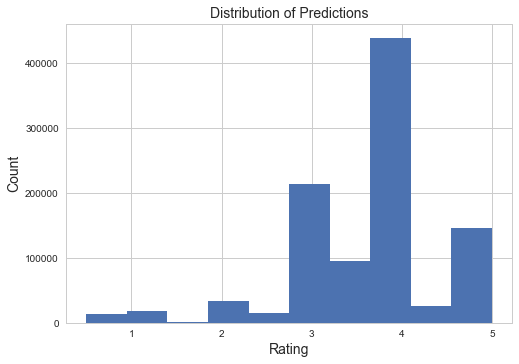

In [23]:
y_pred = model.predict(X_eval).asnumpy().argmax(axis=1)
y_pred = (y_pred + 1.) / 2

plt.title("Distribution of Predictions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Rating", fontsize=14)
plt.hist(y_pred)
plt.show()

In [18]:
# An alternate approach to this model is to consider the problem a classification problem instead of a regression problem.

In [19]:
# The network needs only be modified to have 10 hidden units in the final layer, since it is now a 10 class problem, 
# and to use the softmax output designed for classification problems instead of the linear regression output designed 
# for regression problems.

In [20]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings*2-1, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings*2-1, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=10) # 10 hidden units because 10 classes

#y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)
# SoftmaxOutput instead of LinearRegressionOutput because this is a classification problem now
# and we want to use a classification loss function instead of a regression loss function
y_pred = mx.symbol.SoftmaxOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='acc', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 43487.78 samples/sec	accuracy=0.278124
INFO:root:Epoch[0] Batch [500]	Speed: 44067.85 samples/sec	accuracy=0.313752
INFO:root:Epoch[0] Batch [750]	Speed: 44340.24 samples/sec	accuracy=0.360259
INFO:root:Epoch[0] Train-accuracy=0.370711
INFO:root:Epoch[0] Time cost=432.479
INFO:root:Epoch[0] Validation-accuracy=0.371712
INFO:root:Epoch[1] Batch [250]	Speed: 44983.28 samples/sec	accuracy=0.375171
INFO:root:Epoch[1] Batch [500]	Speed: 44311.91 samples/sec	accuracy=0.381417
INFO:root:Epoch[1] Batch [750]	Speed: 44216.15 samples/sec	accuracy=0.387433
INFO:root:Epoch[1] Train-accuracy=0.390147
INFO:root:Epoch[1] Time cost=426.554
INFO:root:Epoch[1] Validation-accuracy=0.387334
INFO:root:Epoch[2] Batch [250]	Speed: 45064.81 samples/sec	accuracy=0.391359
INFO:root:Epoch[2] Batch [500]	Speed: 44725.70 samples/sec	accuracy=0.393562
INFO:root:Epoch[2] Batch [750]	Speed: 44787.97 samples/sec	accuracy=0.396111
INFO:root:Epoch[2] Train-accuracy=0.397804
INFO:roo

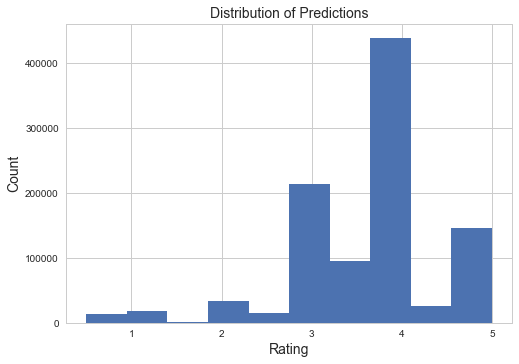

In [21]:
y_pred = model.predict(X_eval).asnumpy().argmax(axis=1)
y_pred = (y_pred + 1.) / 2

plt.title("Distribution of Predictions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Rating", fontsize=14)
plt.hist(y_pred)
plt.show()

In [22]:
# Structural Regularization in Deep Matrix Factorization

In [24]:
# It appears that this methid does not work that well compared to optimizing the RMSE directly for this specific dataset. 
# However, this opens the door to using MXNet to solve all types of matrix completion problems that have categories
# that need to be predicted instead of real values.

In [25]:
# By changing the number of user factors from 25 to 15 we can reduce the number of parameters by 1.38 million 
# while not losing any expressivity on the movie side. The only change is changing the value of output_dim 
# in the user embedding layer.

In [27]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15) # Using 15 instead of 25 here

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu') 
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 47806.84 samples/sec	rmse=1.531881
INFO:root:Epoch[0] Batch [500]	Speed: 47132.75 samples/sec	rmse=0.870055
INFO:root:Epoch[0] Batch [750]	Speed: 49274.98 samples/sec	rmse=0.862605
INFO:root:Epoch[0] Train-rmse=0.860803
INFO:root:Epoch[0] Time cost=395.542
INFO:root:Epoch[0] Validation-rmse=0.861108
INFO:root:Epoch[1] Batch [250]	Speed: 49768.74 samples/sec	rmse=0.858528
INFO:root:Epoch[1] Batch [500]	Speed: 49261.96 samples/sec	rmse=0.851822
INFO:root:Epoch[1] Batch [750]	Speed: 49538.81 samples/sec	rmse=0.840869
INFO:root:Epoch[1] Train-rmse=0.836234
INFO:root:Epoch[1] Time cost=383.325
INFO:root:Epoch[1] Validation-rmse=0.839120
INFO:root:Epoch[2] Batch [250]	Speed: 48939.78 samples/sec	rmse=0.833968
INFO:root:Epoch[2] Batch [500]	Speed: 53983.83 samples/sec	rmse=0.830211
INFO:root:Epoch[2] Batch [750]	Speed: 52210.29 samples/sec	rmse=0.826997
INFO:root:Epoch[2] Train-rmse=0.824456
INFO:root:Epoch[2] Time cost=368.643
INFO:root:Epoch[2] Validati

In [28]:
# Next, we can extend matrix factorization past using only two embedding layers. 
# The MovieLens dataset comes with genres for each of the films. Presumably genre is one of the major aspects 
# that would be learned by the movie embedding layer already, so explicitly including that information can be beneficial.

In [29]:
genres = pandas.read_csv('./ml-20m/movies.csv')
genres.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
labels_str = [label.split("|")[0] for label in genres['genres']]
label_set = numpy.unique(labels_str)
label_idxs = {l: i for i, l in enumerate(label_set)}
label_idxs

{'(no genres listed)': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 'Children': 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'IMAX': 12,
 'Musical': 13,
 'Mystery': 14,
 'Romance': 15,
 'Sci-Fi': 16,
 'Thriller': 17,
 'War': 18,
 'Western': 19}

In [31]:
labels = numpy.empty(n_movies)
for movieId, label in zip(genres['movieId'], labels_str):
    labels[movieId-1] = label_idxs[label]

train_genres = numpy.array([labels[int(j)] for j in train_movies])
valid_genres = numpy.array([labels[int(j)] for j in valid_movies])
train_genres[:10]

array([  8.,   6.,   6.,   8.,   1.,  10.,   1.,  11.,   8.,  11.])

In [33]:
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies, 'movie_genre': train_genres}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies, 'movie_genre': valid_genres}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=15)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=20) # Reduce from 25 to 20

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(0), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=5, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [250]	Speed: 43234.11 samples/sec	rmse=1.551715
INFO:root:Epoch[0] Batch [500]	Speed: 42929.87 samples/sec	rmse=0.869840
INFO:root:Epoch[0] Batch [750]	Speed: 43106.30 samples/sec	rmse=0.862559
INFO:root:Epoch[0] Train-rmse=0.860810
INFO:root:Epoch[0] Time cost=441.004
INFO:root:Epoch[0] Validation-rmse=0.861121
INFO:root:Epoch[1] Batch [250]	Speed: 43035.55 samples/sec	rmse=0.858501
INFO:root:Epoch[1] Batch [500]	Speed: 46424.86 samples/sec	rmse=0.851766
INFO:root:Epoch[1] Batch [750]	Speed: 46640.66 samples/sec	rmse=0.843579
INFO:root:Epoch[1] Train-rmse=0.839363
INFO:root:Epoch[1] Time cost=419.841
INFO:root:Epoch[1] Validation-rmse=0.842081
INFO:root:Epoch[2] Batch [250]	Speed: 46797.35 samples/sec	rmse=0.836849
INFO:root:Epoch[2] Batch [500]	Speed: 46948.03 samples/sec	rmse=0.832471
INFO:root:Epoch[2] Batch [750]	Speed: 46355.20 samples/sec	rmse=0.830100
INFO:root:Epoch[2] Train-rmse=0.828022
INFO:root:Epoch[2] Time cost=406.621
INFO:root:Epoch[2] Validati